# Elo Merchant Category Recommendation - LynxKite co-location <a class="tocSkip">
*End date: 2019. february 19.*

This tutorial notebook is the first part of a seriers for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [1]:
import os
import gc
import math
import scipy
import random
import warnings
import datetime
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.mlab import normpdf
from imblearn.over_sampling import SMOTE
from IPython.core.display import display, HTML
from statsmodels.graphics.gofplots import qqplot

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE

warnings.filterwarnings("ignore")

random.seed(1)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df = pd.read_csv("input/train.csv")
df = reduce_mem_usage(df)

Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)


In [83]:
df_cl = pd.read_csv("input/clustering.csv")
df_cl = reduce_mem_usage(df_cl)

Starting memory usage:  0.85 MB
Reduced memory usage:  0.53 MB (37.5% reduction)


## Analyse the current clusters

We want to see if the clustering performed in LynxKite has any effect in the targets values, both for clusters including outliers and clusters formed only by normal users. The clusters where made connecting users which have purchased something simultaneously to the same merchants (more than one) in more than one different month.

In [87]:
df_cl = df_cl.merge(df[['card_id','target']], left_on='vertex_id', right_on='card_id', how='left').drop('card_id',axis=1).rename(columns={'vertex_id':'card_id'})
df_cl.head()

,card_id,cluster_id,is_out,out_in_cluster,target
0,C_ID_cd6da13f43,6269582809598431975,0.0,0.0,-0.134888
1,C_ID_d4d95404a5,5798750399913586507,NaN,0.0,NaN
2,C_ID_aea83a6829,-5916678927572335962,NaN,0.0,NaN
3,C_ID_1691a18d46,-200028850451410391,NaN,0.0,NaN
4,C_ID_fb1b30af92,8832349727371794727,0.0,0.0,0.383545


All the non-defined values for the target correspond to test users. <br>
First let's change the cluster_id to get integer numbers.

In [89]:
#New ids for the clusters
df_map = pd.DataFrame(df_cl['cluster_id'].unique()).rename({0:'cluster_id'}, axis=1)
df_map['cluster_num'] = df_map.index+1 

#Map the ids to the new values
temp = df_map.transpose() 
temp.columns = temp.iloc[0]
temp = temp.drop('cluster_id').to_dict(orient='records')[0]
df_cl['cluster_num'] = df_cl['cluster_id'].map(temp)

#Rename the columns
df_cl = df_cl.drop('cluster_id',axis=1).rename(columns={'cluster_num': 'cluster_id'})
df_cl.head()

,card_id,is_out,out_in_cluster,target,cluster_id
0,C_ID_cd6da13f43,0.0,0.0,-0.134888,1
1,C_ID_d4d95404a5,NaN,0.0,NaN,2
2,C_ID_aea83a6829,NaN,0.0,NaN,3
3,C_ID_1691a18d46,NaN,0.0,NaN,4
4,C_ID_fb1b30af92,0.0,0.0,0.383545,5


Let's plot now the targets for clusters in some clusters with more than 5 train users.

In [93]:
df_cl_train_size = df_cl[df_cl['target'].notnull()].groupby('cluster_id').size().reset_index().rename({0:'size'}, axis=1)
clusters_5 = df_cl_train_size[df_cl_train_size['size']>5]['cluster_id'].values

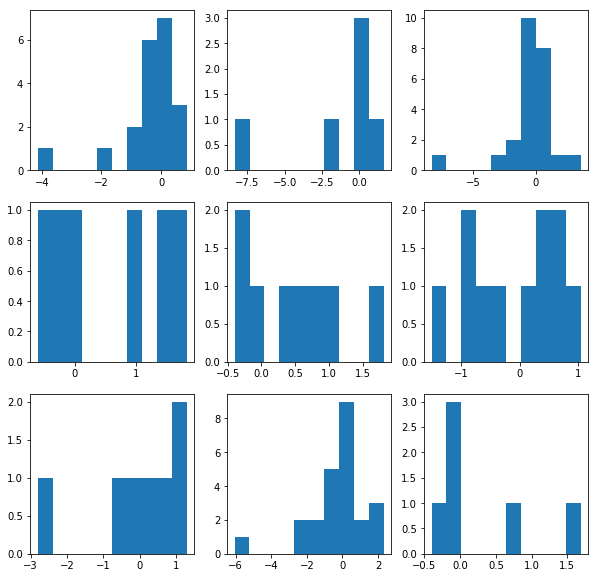

In [95]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.hist(df_cl[df_cl['cluster_id']==clusters_5[i]]['target'])
plt.show()

It doen's seem to be a clear pattern of the target values inside a cluster. However, the loyalty score may not be viral, so there ir no real reason to expect such a patter. However churn is viral, so let's see if there is some pattern in the clusters containing outliers.

In [108]:
#Clusters with more than 1 outlier
df_cl[['cluster_id','is_out']].groupby('cluster_id').sum().reset_index().sort_values(by='is_out',ascending=False).rename({'is_out':'n_outs'}, axis=1).head(4)

,cluster_id,n_outs
113,114,2.0
1900,1901,2.0
563,564,2.0
7179,7180,2.0


In [107]:
df_cl[df_cl['cluster_id'].isin([114,1901,564,7180])].groupby('cluster_id').size().reset_index().rename({0:'size'}, axis=1)

,cluster_id,size
0,114,40
1,564,8
2,1901,38
3,7180,2


We saw that the last cluster has only two users, and both of them are outliers. So maybe the clusters are able to detect churn patterns.

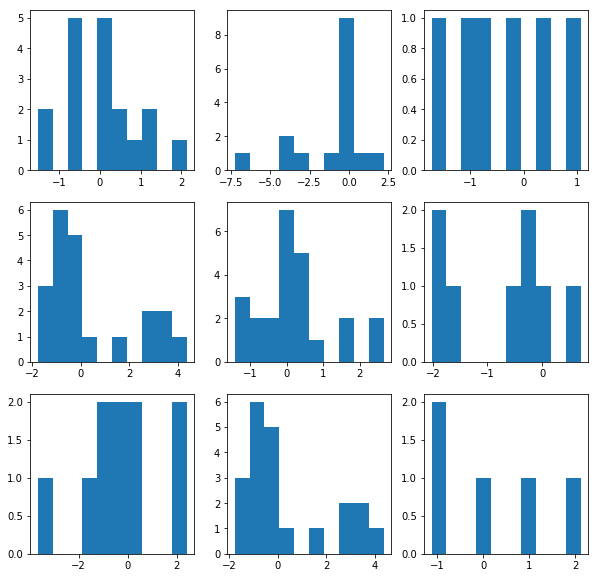

In [126]:
clusters_out_5 = df_cl[(df_cl['cluster_id'].isin(clusters_5)) & (df_cl['out_in_cluster']==1)]['cluster_id'].values
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    values_plot = df_cl[df_cl['cluster_id']==clusters_out_5[i]]['target'].values
    plt.hist(values_plot[values_plot>(-30)])
plt.show()

It doesn't seem to be a pattern neither. Let's then analyse if for small clusters with outliers we can see something.

In [143]:
df_size_outs = df_cl['target'][df_cl['out_in_cluster']==1].notnull().groupby(df_cl['cluster_id']).sum().reset_index().rename({'target':'notnull_targets'}, axis=1)
df_cl_outs = df_cl.merge(df_size_outs, on='cluster_id')
df_cl_outs.head()

,card_id,is_out,out_in_cluster,target,cluster_id,notnull_targets
0,C_ID_a90c4c480f,NaN,1.0,NaN,6,1.0
1,C_ID_417a7742d1,NaN,1.0,NaN,6,1.0
2,C_ID_c14207ad7e,1.0,1.0,-33.218750,6,1.0
3,C_ID_4053098b39,0.0,1.0,-1.036133,110,4.0
4,C_ID_ecc27ea9a1,0.0,1.0,-0.754883,110,4.0


In [155]:
df_mean_outs = df_cl_outs[df_cl_outs['target']>(-33)][['target','notnull_targets']].groupby('notnull_targets').mean().reset_index().rename({'target':'mean_target'}, axis=1)
df_mean_outs

,notnull_targets,mean_target
0,2.0,-0.119995
1,3.0,-0.203735
2,4.0,-0.401611
3,5.0,-0.131348
4,6.0,-0.058289
5,7.0,-0.672363
6,9.0,-0.155884
7,10.0,-0.423096
8,11.0,-0.332764
9,12.0,0.159790


We can see that the mean target values for the customers sharing cluster with outliers are negative for small clusters (less than 11 train users). The outliers have been removed before performing the means. <br>
However this fact can not be appreciated in the histograms.

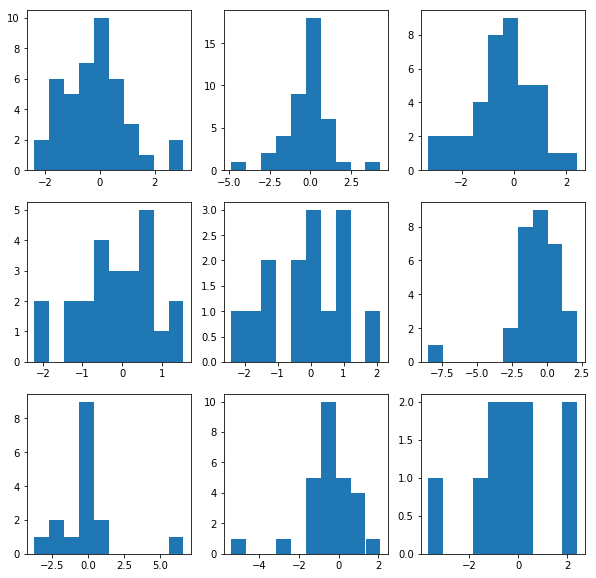

In [156]:
plt.figure(figsize=(10, 10))
sizes = df_mean_outs['notnull_targets'].values
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.hist(df_cl_outs[(df_cl_outs['target']>(-30)) & (df_cl_outs['notnull_targets']==sizes[i])]['target'])
plt.show()

Let's see now the means for all clusters, and not only the ones containing outliers, to see if it is really a special characteristic of clusters contaning outliers.

In [165]:
df_size_all = df_cl['target'].notnull().groupby(df_cl['cluster_id']).sum().reset_index().rename({'target':'notnull_targets'}, axis=1)
df_cl_all = df_cl.merge(df_size_all, on='cluster_id')
df_mean_all = df_cl_all[df_cl_all['target']>(-33)][['target','notnull_targets']].groupby('notnull_targets').mean().reset_index().rename({'target':'mean_target_all'}, axis=1)
df_mean_all

,notnull_targets,mean_target_all
0,1.0,-0.129395
1,2.0,-0.160889
2,3.0,-0.114746
3,4.0,-0.064026
4,5.0,-0.159668
5,6.0,-0.070007
6,7.0,-0.207153
7,8.0,-0.127075
8,9.0,-0.033997
9,10.0,-0.161987


We see that the mean values tend to be negative in general for the vertices within a cluster. Let's plot these two rows together to see it one is less than the other consistently.

In [167]:
df_plot_means = pd.DataFrame(np.arange(1,29),columns=['notnull_targets'])
df_plot_means = df_plot_means.merge(df_mean_outs, on='notnull_targets', how='left')
df_plot_means = df_plot_means.merge(df_mean_all, on='notnull_targets', how='left')

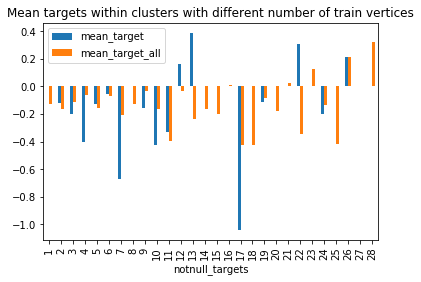

In [188]:
df_plot_means.plot(x='notnull_targets', y=['mean_target', 'mean_target_all'], kind='bar')
plt.title('Mean targets within clusters with different number of train vertices')
plt.show()

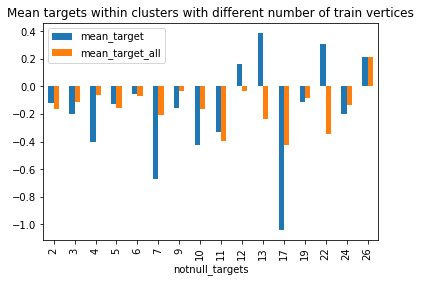

In [189]:
df_plot_means2 = pd.DataFrame(np.arange(1,29),columns=['notnull_targets'])
df_plot_means2 = df_plot_means2.merge(df_mean_outs, on='notnull_targets', how='inner')
df_plot_means2 = df_plot_means2.merge(df_mean_all, on='notnull_targets', how='left')
df_plot_means2.plot(x='notnull_targets', y=['mean_target', 'mean_target_all'], kind='bar')
plt.title('Mean targets within clusters with different number of train vertices')
plt.show()

It is not completelly clear, but at least it might be true for small clusters (containing at most 10 train points). For these clusters the mean target for clusters with outliers is less than the general mean in 5 out of the 8 examples. For bigger clusters we can not conclude anything since we only have one cluster of each size. We can see the number of cluster of each size below:

In [197]:
df_size_outs.groupby('notnull_targets').cluster_id.nunique()

notnull_targets
1.0     28
2.0     43
3.0     21
4.0     13
5.0      6
6.0      3
7.0      5
9.0      2
10.0     3
11.0     1
12.0     1
13.0     1
17.0     1
19.0     2
22.0     1
24.0     1
26.0     1
Name: cluster_id, dtype: int64

## Mark clusters with predominantly negative values

In view of the previous plot, we will mark as "suspicious" the users belonging to clusters containing 3 or 4 train points with mean target values (excluding outliers) less than -0.2.

In [245]:
cut = -0.2
sizes = [3,4]
ids_sizes = df_size_all[df_size_all['notnull_targets'].isin(sizes)]['cluster_id'].values
df_sizes_means = df_cl[(df_cl['cluster_id'].isin(ids_3_4)) & (df_cl['is_out']!=1)].groupby('cluster_id')['target'].mean().reset_index().rename({'target':'mean_target'}, axis=1)
ids_sizes_less = df_sizes_means[df_sizes_means['mean_target']<=cut]['cluster_id'].values
print("We have marked {} clusters as 'suspicious' ({:.2f}% of the clusters).".format(len(ids_sizes_less), len(ids_sizes_less)/df_cl['cluster_id'].nunique()*100))

We have marked 428 clusters as 'suspicious' (4.70% of the clusters).


In [224]:
df_cl['suspicious_cluster'] = 1*(df_cl['cluster_id'].isin(ids_sizes_less))
df_cl.head()

,card_id,is_out,out_in_cluster,target,cluster_id,suspicius_cluster
0,C_ID_cd6da13f43,0.0,0.0,-0.134888,1,0
1,C_ID_d4d95404a5,NaN,0.0,NaN,2,0
2,C_ID_aea83a6829,NaN,0.0,NaN,3,0
3,C_ID_1691a18d46,NaN,0.0,NaN,4,0
4,C_ID_fb1b30af92,0.0,0.0,0.383545,5,0


Now we have to split the customers between train and test to create the new files. The users that do not appear in the cluster file (because they where not connected to anybody in LynxKite) are marked also as no suspicius.

In [228]:
df_test = pd.read_csv("input/test.csv")
df_test = reduce_mem_usage(df_test)

Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)


In [237]:
df = df.merge(df_cl[['card_id','suspicious_cluster']], on='card_id',how='left').fillna(0)
print("We have marked {} customers in the train set as 'suspicious' ({:.2f}% of the set).".format(int(df['suspicious_cluster'].sum()), df['suspicious_cluster'].sum()/df.shape[0]*100))

We have marked 1397 customers in the train set as 'suspicious' (0.69% of the set).


In [239]:
df_test = df_test.merge(df_cl[['card_id','suspicious_cluster']], on='card_id',how='left').fillna(0)
print("We have marked {} customers in the test set as 'suspicious' ({:.2f}% of the set).".format(int(df_test['suspicious_cluster'].sum()), df_test['suspicious_cluster'].sum()/df_test.shape[0]*100))

We have marked 513 customers in the test set as 'suspicious' (0.41% of the set).


We now store the results in csv files.

In [240]:
sub_df = pd.DataFrame({
    "card_id": df["card_id"].values
})

sub_df['suspicious_cluster'] = df['suspicious_cluster']
sub_df.to_csv("output/suspicious_clusters_train.csv", index=False)

In [241]:
sub_df = pd.DataFrame({
    "card_id": df_test["card_id"].values
})

sub_df['suspicious_cluster'] = df_test['suspicious_cluster']
sub_df.to_csv("output/suspicious_clusters_test.csv", index=False)